# LIGO Data Analysis

In this lab, we analyse the data recorded by LIGO in its initial GW150914 graivtional wave signal detection to better understand how to identify and remove noise sources from data.

## 1. Importing Data and Libraries

We import scipy, numpy and matplotlib in order to use the facilities they provide for manipulating data, signal processing and plotting of results. Alternatively, the import of IPython.display is for the reproduction of audio within a jupyter notebook such as this.

In [2]:
import scipy.fft as fft
import scipy.signal as sig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import Audio

matplotlib.rcParams['text.usetex'] = True

Which define a function which reads in the format of the CSV files given in the LIGO dataset.

In [3]:
def get_data(filename):
          data = []
          with open(filename, 'r') as datafile:
              NaNs = 0
              for line in datafile:
                  if line[0] == '#':
                      print(line[:-1])
                  else:
                      try: data += [float(line)]
                      except ValueError: NaNs += 1
              if NaNs > 0:
                  print('Warning:\n ', NaNs, 'lines couldn\'t be read as numbers\n')
          return np.array(data)

In [4]:
H1_data = get_data("H-H1_GWOSC_4KHZ_R1-1126259447-32.txt")
L1_data = get_data("L-L1_GWOSC_4KHZ_R1-1126259447-32.txt")

# Since we have a sample frequency of 4096 Hz, the sample time will be the number of samples divided by this.
sample_rate = 4096
sample_time = len(H1_data)/sample_rate
int_sample_time = int(sample_time)
num_samples = len(H1_data)

print("Sample time: " + str(sample_time))
print("Int sample time: " + str(int_sample_time))
print("Number samples: " + str(num_samples))

# Gravitational wave strain for GW150914_R1 for H1 (see http://losc.ligo.org)
# This file has 4096 samples per second
# starting GPS 1126259447 duration 32
# Gravitational wave strain for GW150914_R1 for L1 (see http://losc.ligo.org)
# This file has 4096 samples per second
# starting GPS 1126259447 duration 32
Sample time: 32.0
Int sample time: 32
Number samples: 131072


## 2a Plotting Data Sets for Both Detectors

We use the typical matplotlib library to plot the data.

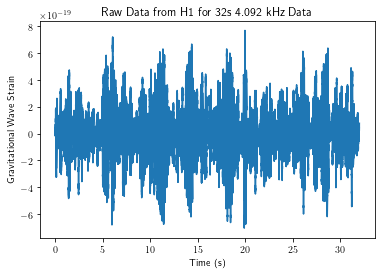

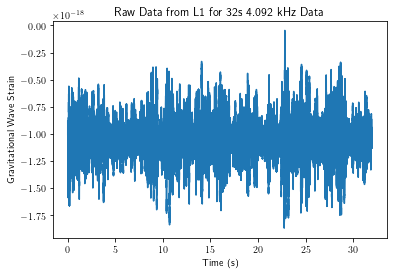

In [5]:
# This array includes time across all of the raw data
time_for_raw_data = np.linspace(0, sample_time, num_samples)

plot1 = plt.figure(1)
line = plt.plot(time_for_raw_data, H1_data)
plt.title("Raw Data from H1 for 32s 4.092 kHz Data")
plt.ylabel("Gravitational Wave Strain")
plt.xlabel("Time (s)")
plt.show()

plot2 = plt.figure(2)
line = plt.plot(time_for_raw_data, L1_data)
plt.title("Raw Data from L1 for 32s 4.092 kHz Data")
plt.ylabel("Gravitational Wave Strain")
plt.xlabel("Time (s)")
plt.show()

We can see that there is a lot of noise in the data and there is no discernable spike shared between the two data sources. Although one may point to the spikes at 20 s on graph 1 and 22.5 s on gaph 2, as we will see they are not representatitive of the gravitational wave detection. From here, we must take the Fourier transform and process the signal further.

## 2b Plotting Fourier Transform

In [6]:
# Generate a frequency axis using the inbuilt function
freq_axis = fft.rfftfreq(num_samples, 1/sample_rate)

# Since our data is real, we take the real Fourier transform using SciPy's rfft function.
H1_data_raw_rfft = fft.rfft(H1_data)
L1_data_raw_rfft = fft.rfft(L1_data)

# We take the absolute values to plot a more realistic transform 
abs_H1_data_raw_rfft = abs(H1_data_raw_rfft)
abs_L1_data_raw_rfft = abs(L1_data_raw_rfft)

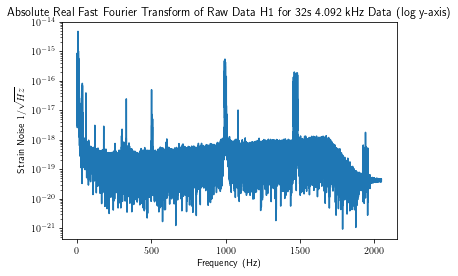

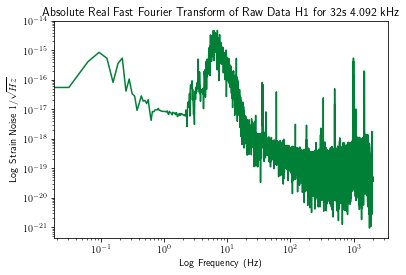

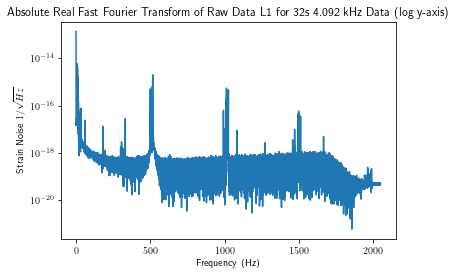

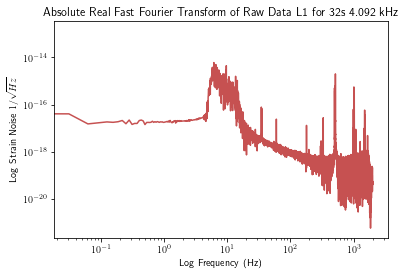

In [13]:
# This has a linear x scale and a log y scale
plot3 = plt.figure(3)
line = plt.plot(freq_axis, abs_H1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data H1 for 32s 4.092 kHz Data (log y-axis)")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

# This has a log x and y scale
plot4 = plt.figure(4)
line = plt.plot(freq_axis, abs_H1_data_raw_rfft, color='#008037')
plt.title("Absolute Real Fast Fourier Transform of Raw Data H1 for 32s 4.092 kHz")
plt.xscale("log")
plt.xlabel("Log Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Log Strain Noise $1/\sqrt{Hz}$")
plt.savefig('rawH1.png', dpi=500)
plt.show()

# This has a linear x scale and a log y scale
plot5 = plt.figure(5)
line = plt.plot(freq_axis, abs_L1_data_raw_rfft)
plt.title("Absolute Real Fast Fourier Transform of Raw Data L1 for 32s 4.092 kHz Data (log y-axis)")
plt.xlabel("Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Strain Noise $1/\sqrt{Hz}$")
plt.show()

# This has a log x and y scale
plot6 = plt.figure(6)
line = plt.plot(freq_axis, abs_L1_data_raw_rfft, color='#c65151')
plt.title("Absolute Real Fast Fourier Transform of Raw Data L1 for 32s 4.092 kHz")
plt.xscale("log")
plt.xlabel("Log Frequency (Hz)")
plt.yscale("log")
plt.ylabel("Log Strain Noise $1/\sqrt{Hz}$")
plt.savefig('rawL1.png', dpi=500)
plt.show()

These plots look similar to the ones produced in (https://iopscience.iop.org/article/10.1088/1361-6382/ab685e#cqgab685es2) and thus we have confidence in the method used. Indeed, the same peaks occur around 250, 500 and 1000 Hz as in figure 2 of the paper. We also see the same general shape as in the paper, with higher strain noise at lower frquencies and then a section of relatively consant noise from 100 Hz, with peaks up to 2000 Hz. Such peaks could represent noise shared across the temporal spectrum or one off events such as the gravitational wave detection. To distinguish between these, we can chunk the data as we do below.

## 3i Function Returning Two-Seocnd Chunks of Data

To whiten the noise we first write a function which reutrns a two-second long chunk of data starting from an arbitrary time. Say t=4,5,6...

In [15]:
def twoSecondChunk(t_start, data):
    
    # Converts time into sample start
    sample_start = int(t_start * sample_rate)
    
    # If sample start is within the appropriate range, returns the requisite data
    if sample_start <= num_samples - 4096*2 and sample_start >= 0:
        sample_end = sample_start + 4096*2
        return data[sample_start:sample_end]
    
    # If not within range, returns None
    else:
        return None

## 3ii Chunking Data

We chunk the data into a list of 31 entries using the above function where we iterate every second such that for each two second bucket there is an overlap of a second with the next bucket.

In [16]:
chunked_H1_data = []
chunked_L1_data = []

for t in range(0,int(sample_time-1)):
    chunked_H1_data.append(twoSecondChunk(t, H1_data))
    chunked_L1_data.append(twoSecondChunk(t, L1_data))

## 3iii Applying the Tukey Window

We apply a Tukey window to each chunk in order to filter out data near the edges of each chunk. This is to avoid artefacts. We do so by iterating of the chunked lists and use the scipy function sig.windows.tukey with a size proportional to 2 seconds 

In [17]:
# Tukey array with number of samples for each two second chunk.
tukey_array = sig.windows.tukey(sample_rate*2)

tukey_chunked_H1_data = []
tukey_chunked_L1_data = []

# In each loop we multiply the chunk data by the tukey window.
for chunk in chunked_H1_data:
    tukey_chunked_H1_data.append(chunk * tukey_array)

for chunk in chunked_L1_data:
    tukey_chunked_L1_data.append(chunk * tukey_array)

## 3iv Applying Fourier Transform to Each Chunk and Average Noise

We apply a real fast fourier transform to each chunk in order to find the average noise in each frequency bin. This relates back to the idea of distinguishing the Fourier transform peaks.

In [18]:
tukey_chunked_rfft_H1_data = []
tukey_chunked_rfft_L1_data = []

# In each loop we append the Fourier transform to our list of chunks
for tukey_chunk in tukey_chunked_H1_data:
    tukey_chunked_rfft_H1_data.append(fft.rfft(tukey_chunk))

for tukey_chunk in tukey_chunked_L1_data:
    tukey_chunked_rfft_L1_data.append(fft.rfft(tukey_chunk))

In [19]:
freq_bin_average_rfft_H1_data = []
freq_bin_average_rfft_L1_data = []

# We generate an average over all of the chunks in each data set for each frequency and then
# append those to a list for each of the sets. 
for freq_bin in range(len(tukey_chunked_rfft_H1_data[0])):
    sum_freq = 0
    for chunk in tukey_chunked_rfft_H1_data:
        # Note here we take the absolute value, as we want the magnitude of the noise
        sum_freq += abs(chunk[freq_bin])
    freq_bin_average_rfft_H1_data.append(sum_freq / len(tukey_chunked_rfft_H1_data))
    
    sum_freq = 0
    
    for chunk in tukey_chunked_rfft_L1_data:
        sum_freq += abs(chunk[freq_bin])
    freq_bin_average_rfft_L1_data.append(sum_freq / len(tukey_chunked_rfft_L1_data))

## 3v Dividing Chunks and Finding Inverse

Having found the average value for each frequency bin across the entire data set, we may iterate through the chunks and divide by this value in each frequency bin. This should scale down any signal which is present across all of the temporal axis for a bin, thus leaving frequency peaks which occur at a specific time (as we will see, in our case this is at around t=14)

In [20]:
normalised_tukey_chunked_rfft_H1_data = []
normalised_tukey_chunked_rfft_L1_data = []

# Each loop takes the old chunk, defines a new chunk and populates that chunk with the 
# frequency bins of the old chunk divided by the average noise for that bin
for chunk in tukey_chunked_rfft_H1_data:
    new_chunk = []
    for i, freq_bin_value in enumerate(chunk):
        new_chunk.append(freq_bin_value/freq_bin_average_rfft_H1_data[i])
    normalised_tukey_chunked_rfft_H1_data.append(new_chunk)

for chunk in tukey_chunked_rfft_L1_data:
    new_chunk = []
    for i, freq_bin_value in enumerate(chunk):
        new_chunk.append(freq_bin_value/freq_bin_average_rfft_L1_data[i])
    normalised_tukey_chunked_rfft_L1_data.append(new_chunk)

In [21]:
# Here we define a function which takes in the two datasets and return the inverse Fourier transform of each 
# of the chunks in both sets and returns these as a list for each dataset
def inverse_chunks(H1_chunks, L1_chunks):
    
    inverse_normalised_tukey_chunked_rfft_H1_data = []
    inverse_normalised_tukey_chunked_rfft_L1_data = []
    
    for chunk in normalised_tukey_chunked_rfft_H1_data:
        inverse_transform_chunk = fft.irfft(chunk)
        inverse_normalised_tukey_chunked_rfft_H1_data.append(inverse_transform_chunk)

    for chunk in normalised_tukey_chunked_rfft_L1_data:
        inverse_transform_chunk = fft.irfft(chunk)
        inverse_normalised_tukey_chunked_rfft_L1_data.append(inverse_transform_chunk)
    
    return inverse_normalised_tukey_chunked_rfft_H1_data, inverse_normalised_tukey_chunked_rfft_L1_data

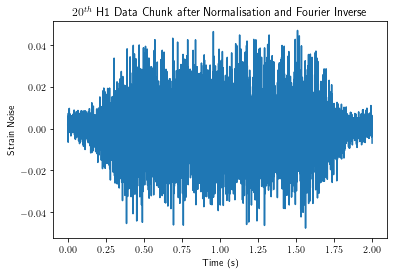

In [23]:
# We define our time axis to be over 2 seconds (like the chunks we are working with)
time_axis = np.linspace(0,2, sample_rate*2)

# Here we take the inverse of the normalised chunks
inverse_normalised_tukey_chunked_rfft_H1_data, inverse_normalised_tukey_chunked_rfft_L1_data = \
inverse_chunks(normalised_tukey_chunked_rfft_H1_data, normalised_tukey_chunked_rfft_L1_data)

plt.plot(time_axis, inverse_normalised_tukey_chunked_rfft_H1_data[20])
plt.title("$20^{th}$ H1 Data Chunk after Normalisation and Fourier Inverse")
plt.xlabel("Time (s)")
plt.ylabel("Strain Noise")
plt.show()

As we can see, after normalisation and the Fourier inverse, the large spike which appeared at around 20 seconds in the raw data graph, does not appear here. This indicates that the spike was the result of a phenomenon outside of the gravitational wave detection.

## 4 & 5 Signal FIltering with Butterworth

To further filter the signal we have generated with the inverse Fourier transform, we use a butter worth pand-pass filter. As suggested by (https://iopscience.iop.org/article/10.1088/1361-6382/ab685e#cqgab685es2), we use a 7th order filter with low 35 Hz and high 350 Hz. We also plot all chunks after applying this filter to find the gravitational wave signal.

### Chunk: 0 ###


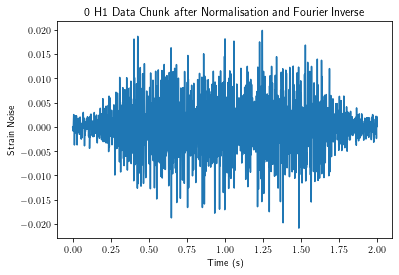

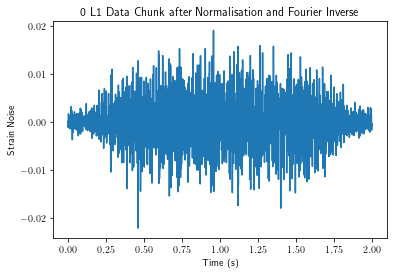

### Chunk: 1 ###


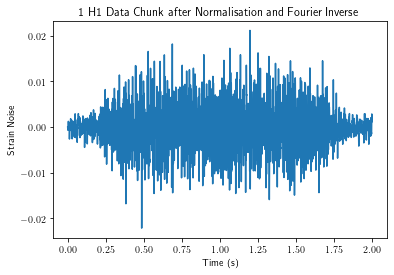

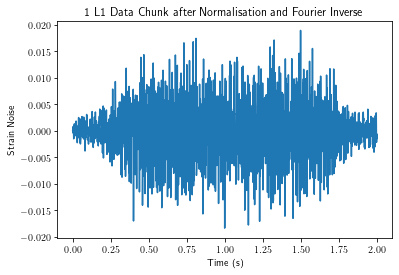

### Chunk: 2 ###


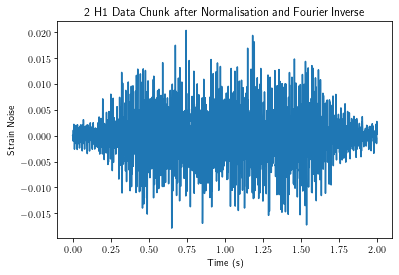

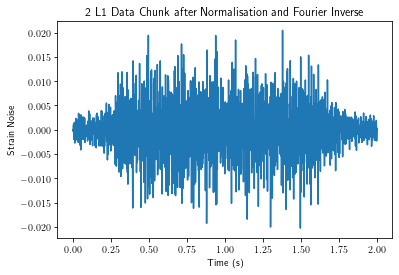

### Chunk: 3 ###


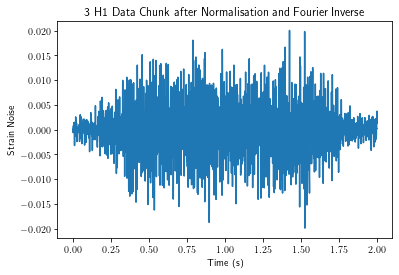

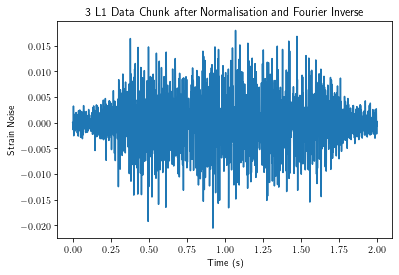

### Chunk: 4 ###


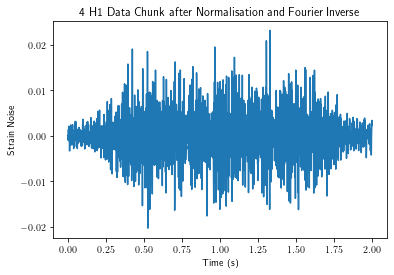

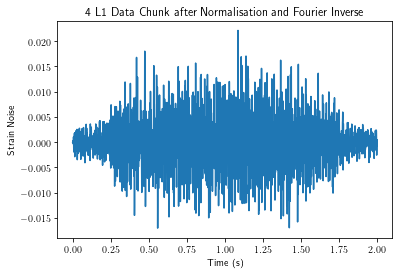

### Chunk: 5 ###


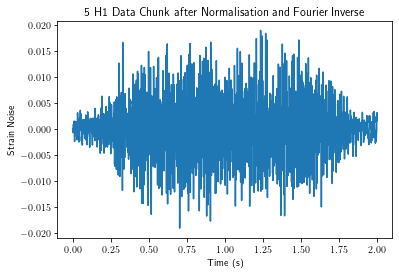

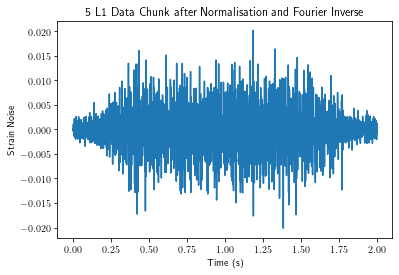

### Chunk: 6 ###


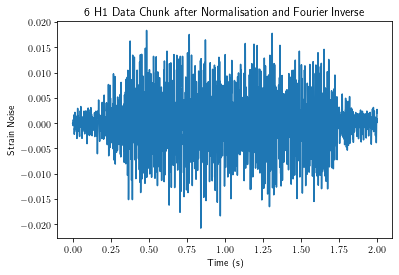

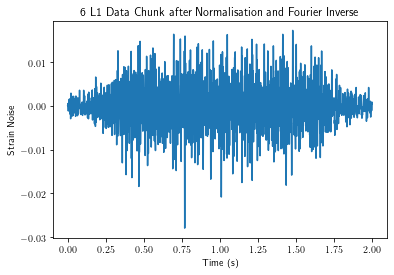

### Chunk: 7 ###


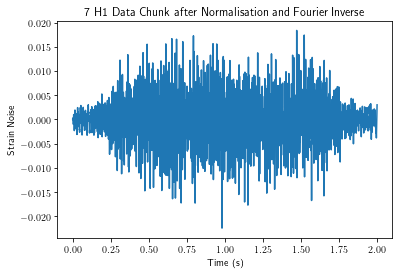

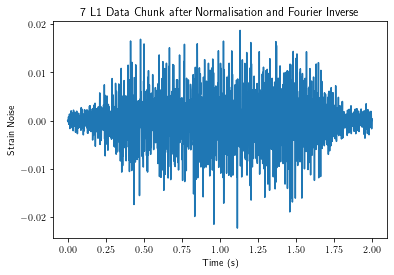

### Chunk: 8 ###


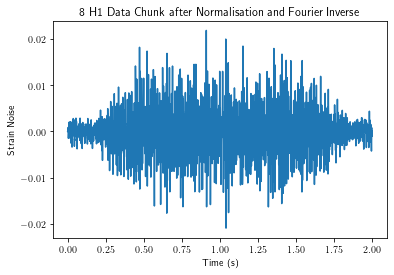

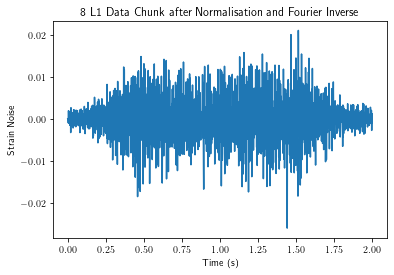

### Chunk: 9 ###


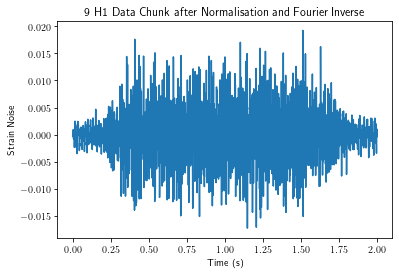

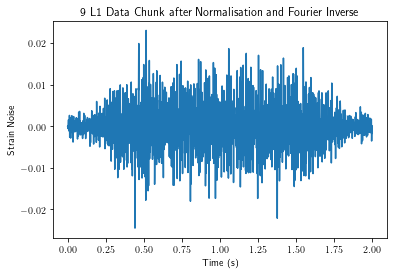

### Chunk: 10 ###


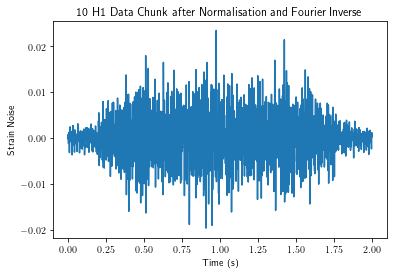

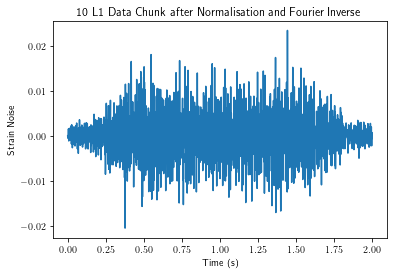

### Chunk: 11 ###


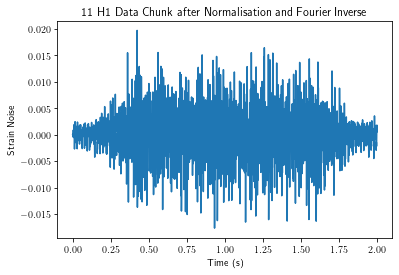

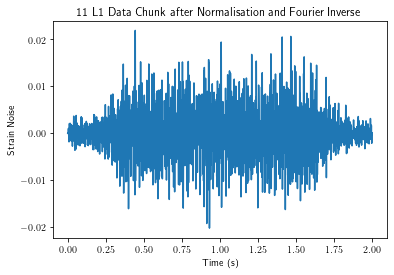

### Chunk: 12 ###


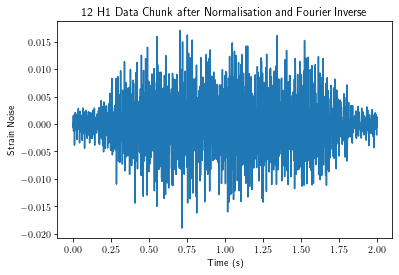

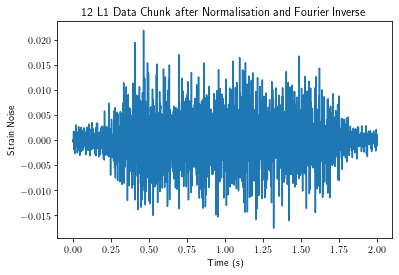

### Chunk: 13 ###


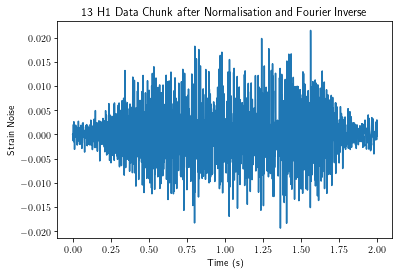

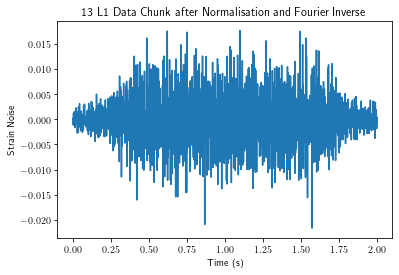

### Chunk: 14 ###


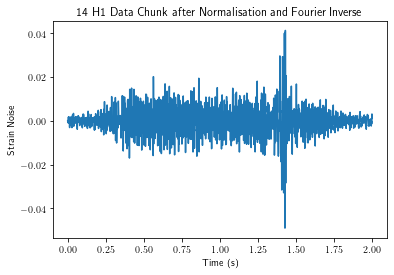

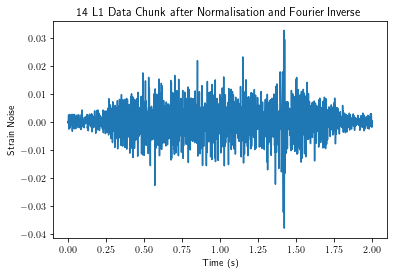

### Chunk: 15 ###


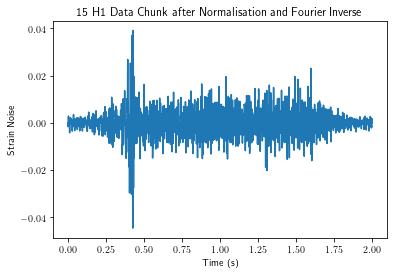

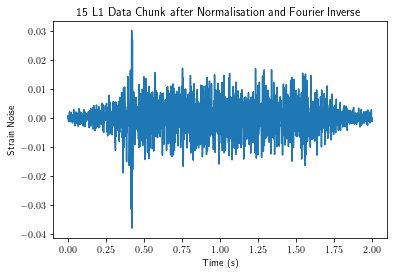

### Chunk: 16 ###


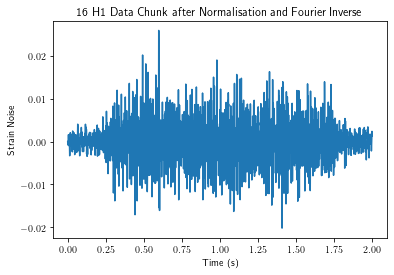

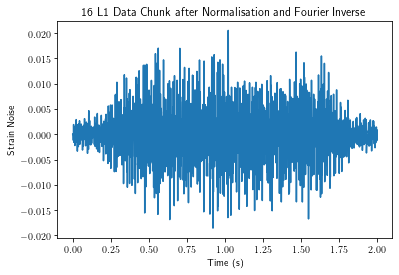

### Chunk: 17 ###


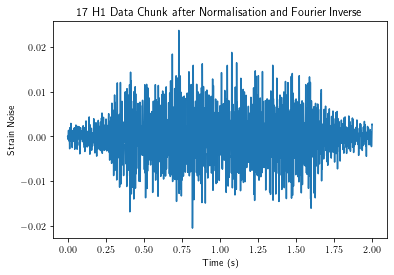

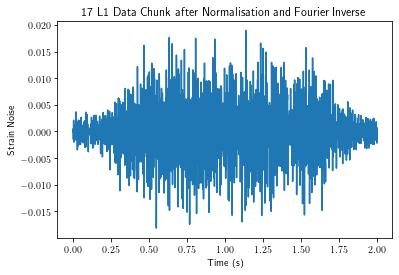

### Chunk: 18 ###


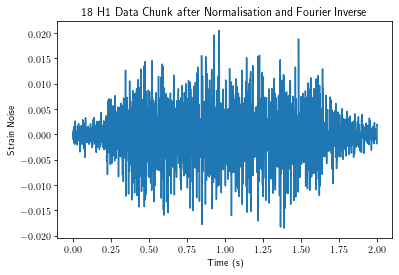

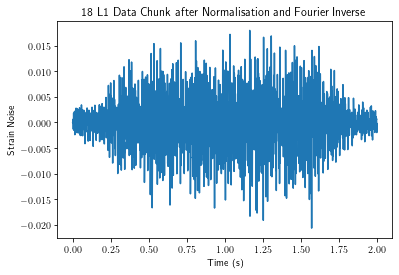

### Chunk: 19 ###


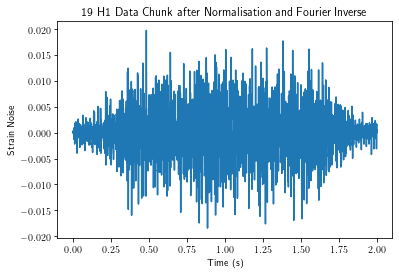

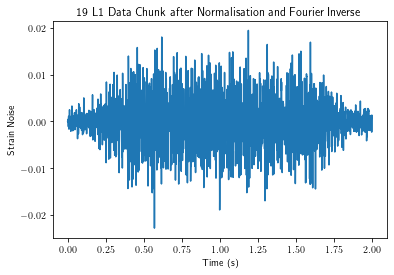

### Chunk: 20 ###


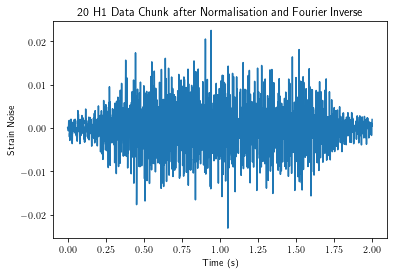

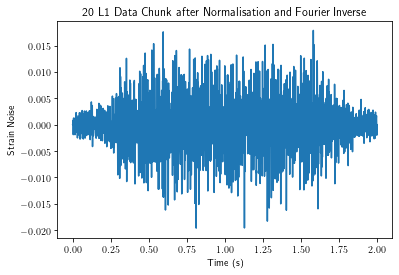

### Chunk: 21 ###


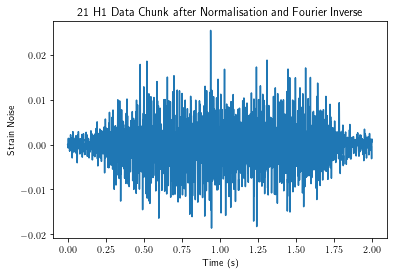

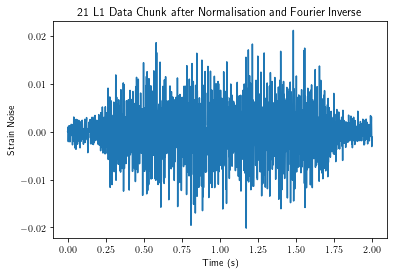

### Chunk: 22 ###


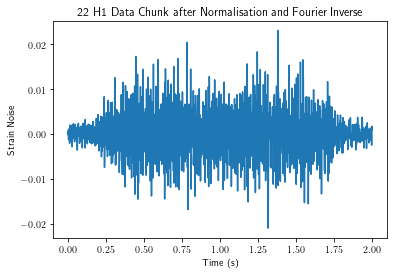

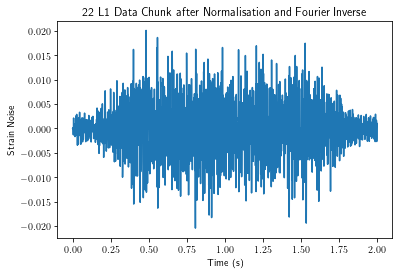

### Chunk: 23 ###


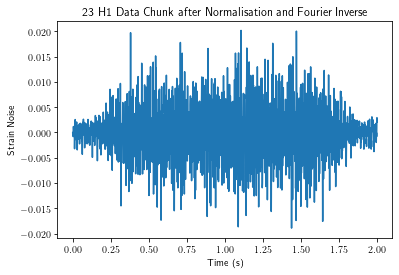

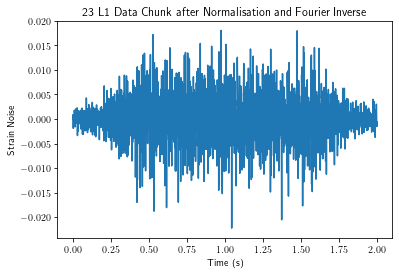

### Chunk: 24 ###


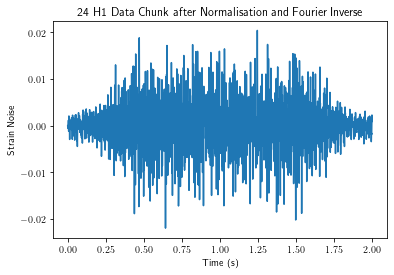

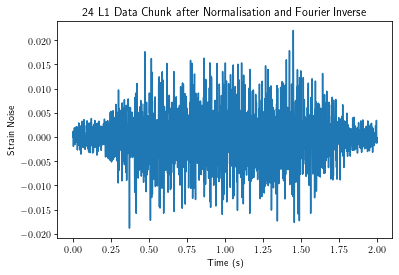

### Chunk: 25 ###


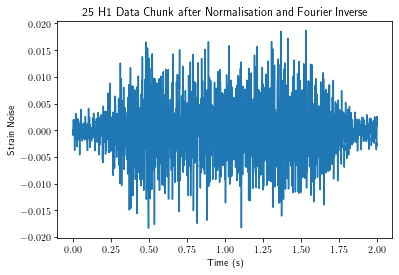

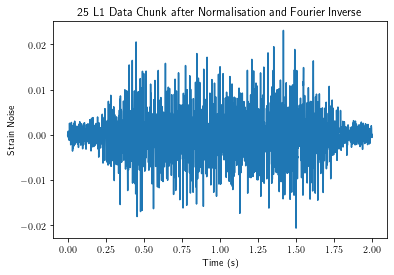

### Chunk: 26 ###


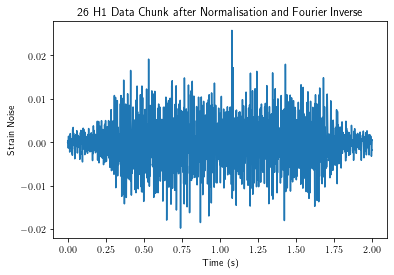

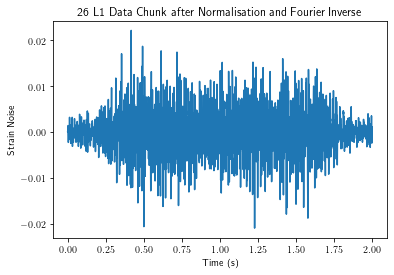

### Chunk: 27 ###


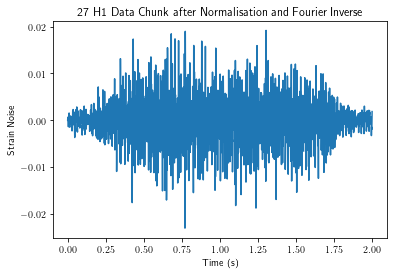

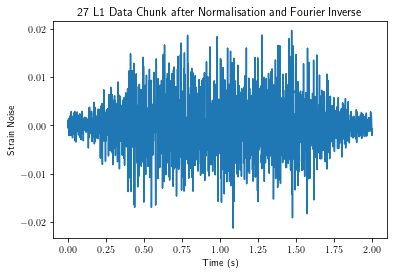

### Chunk: 28 ###


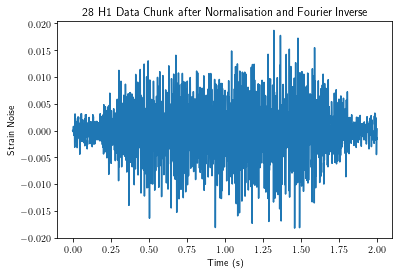

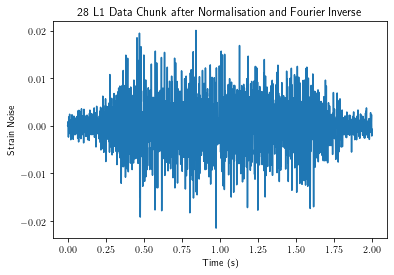

### Chunk: 29 ###


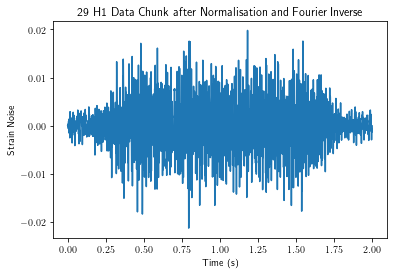

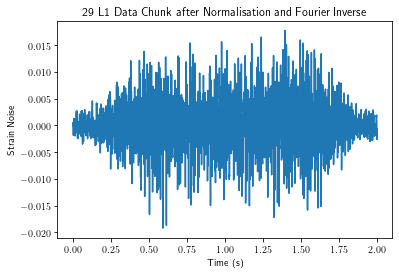

In [24]:
# Creation of Butterworth band-pass filter of order 7 with low 35 Hz, high 350 Hz and sampling frequency 4096.
b, a = sig.butter(7, [35, 350], btype='bandpass', fs=4096)

# We apply the filter object using scipy's signal library
filtered_inverse_butterworth_H1_data = sig.lfilter(b,a,inverse_normalised_tukey_chunked_rfft_H1_data)
filtered_inverse_butterworth_L1_data = sig.lfilter(b,a,inverse_normalised_tukey_chunked_rfft_L1_data)

# Plotting all chunks to find signal
for i in range(0,30):
    print("### Chunk: " + str(i) + " ###")
    plt.plot(time_axis, filtered_inverse_butterworth_H1_data[i])
    plt.title(str(i) + " H1 Data Chunk after Normalisation and Fourier Inverse")
    plt.xlabel("Time (s)")
    plt.ylabel("Strain Noise")
    plt.show()
    
    plt.plot(time_axis, filtered_inverse_butterworth_L1_data[i])
    plt.title(str(i) + " L1 Data Chunk after Normalisation and Fourier Inverse")
    plt.xlabel("Time (s)")
    plt.ylabel("Strain Noise")
    plt.show()

We find the signal within the 14th and 15th chunks as within these there is a peak which is far more significant in magnitude when compared to the rest of the signal. Arbitrarily, we choose the 14th chunk as our reference point and graph the signals from each detector.

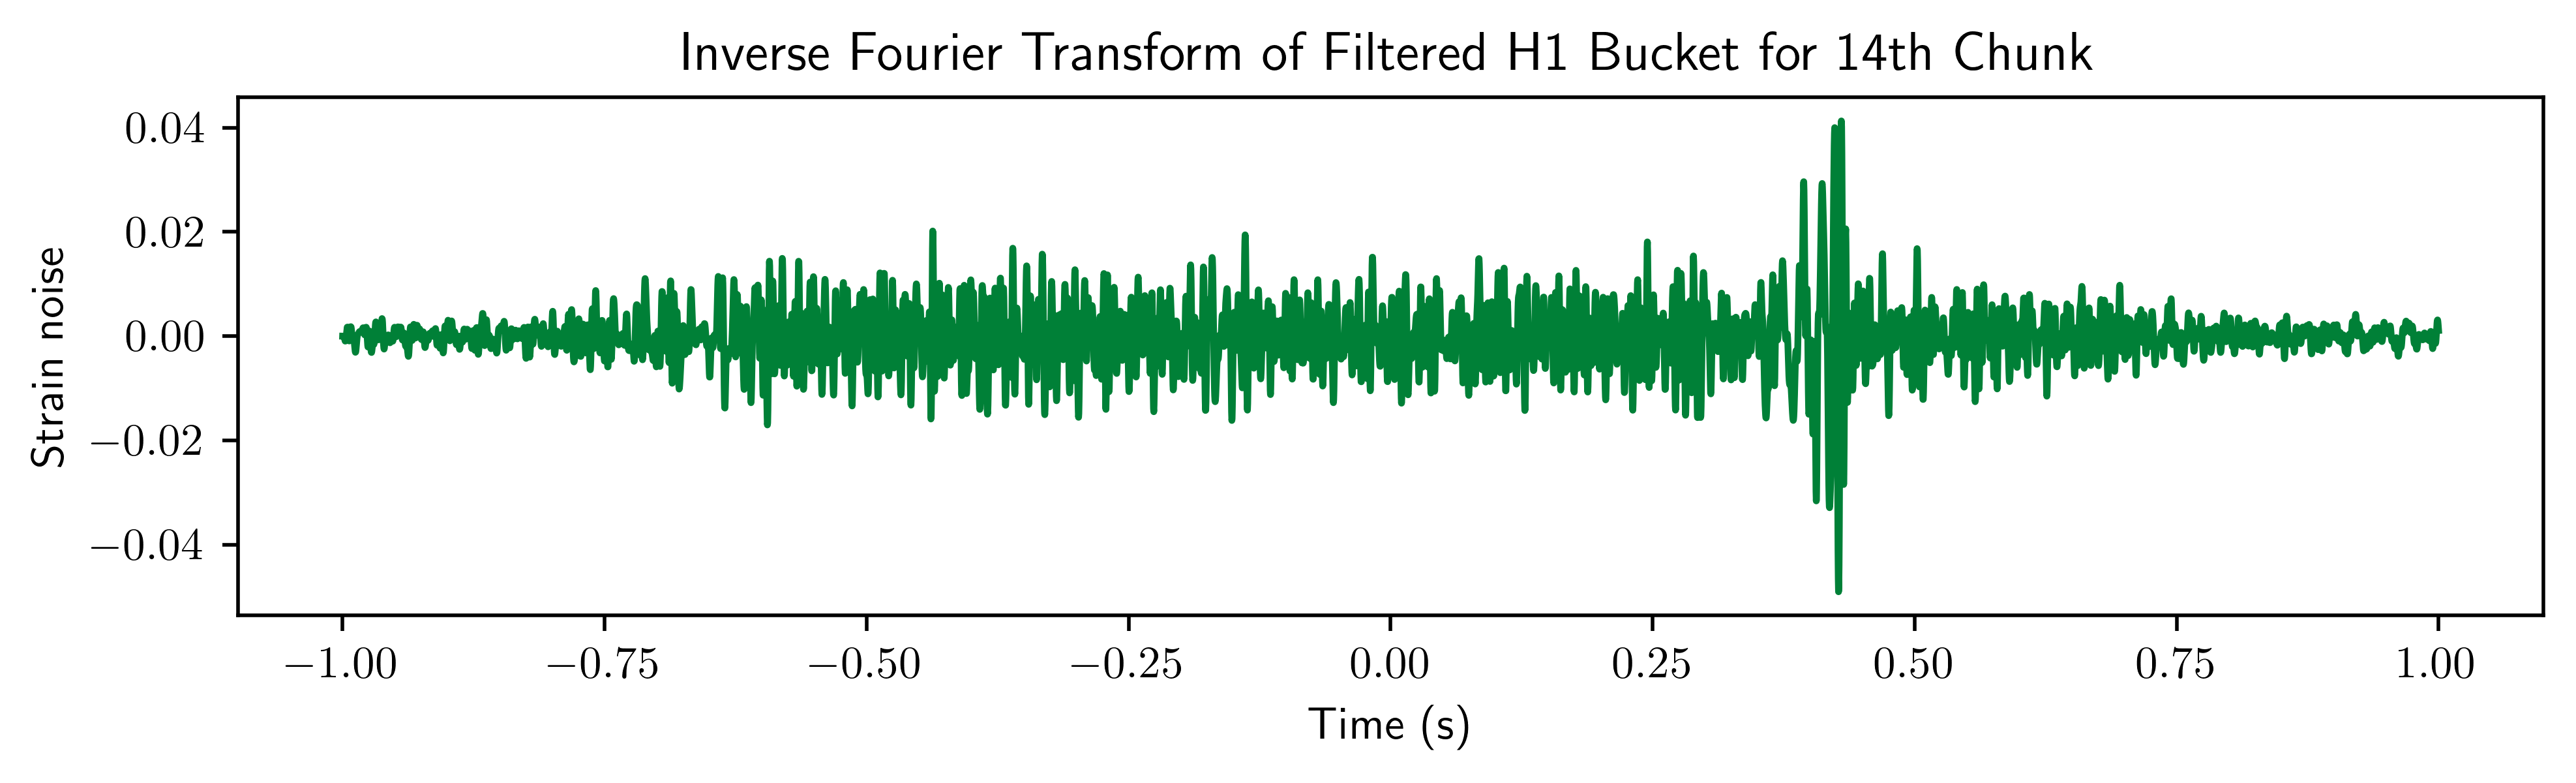

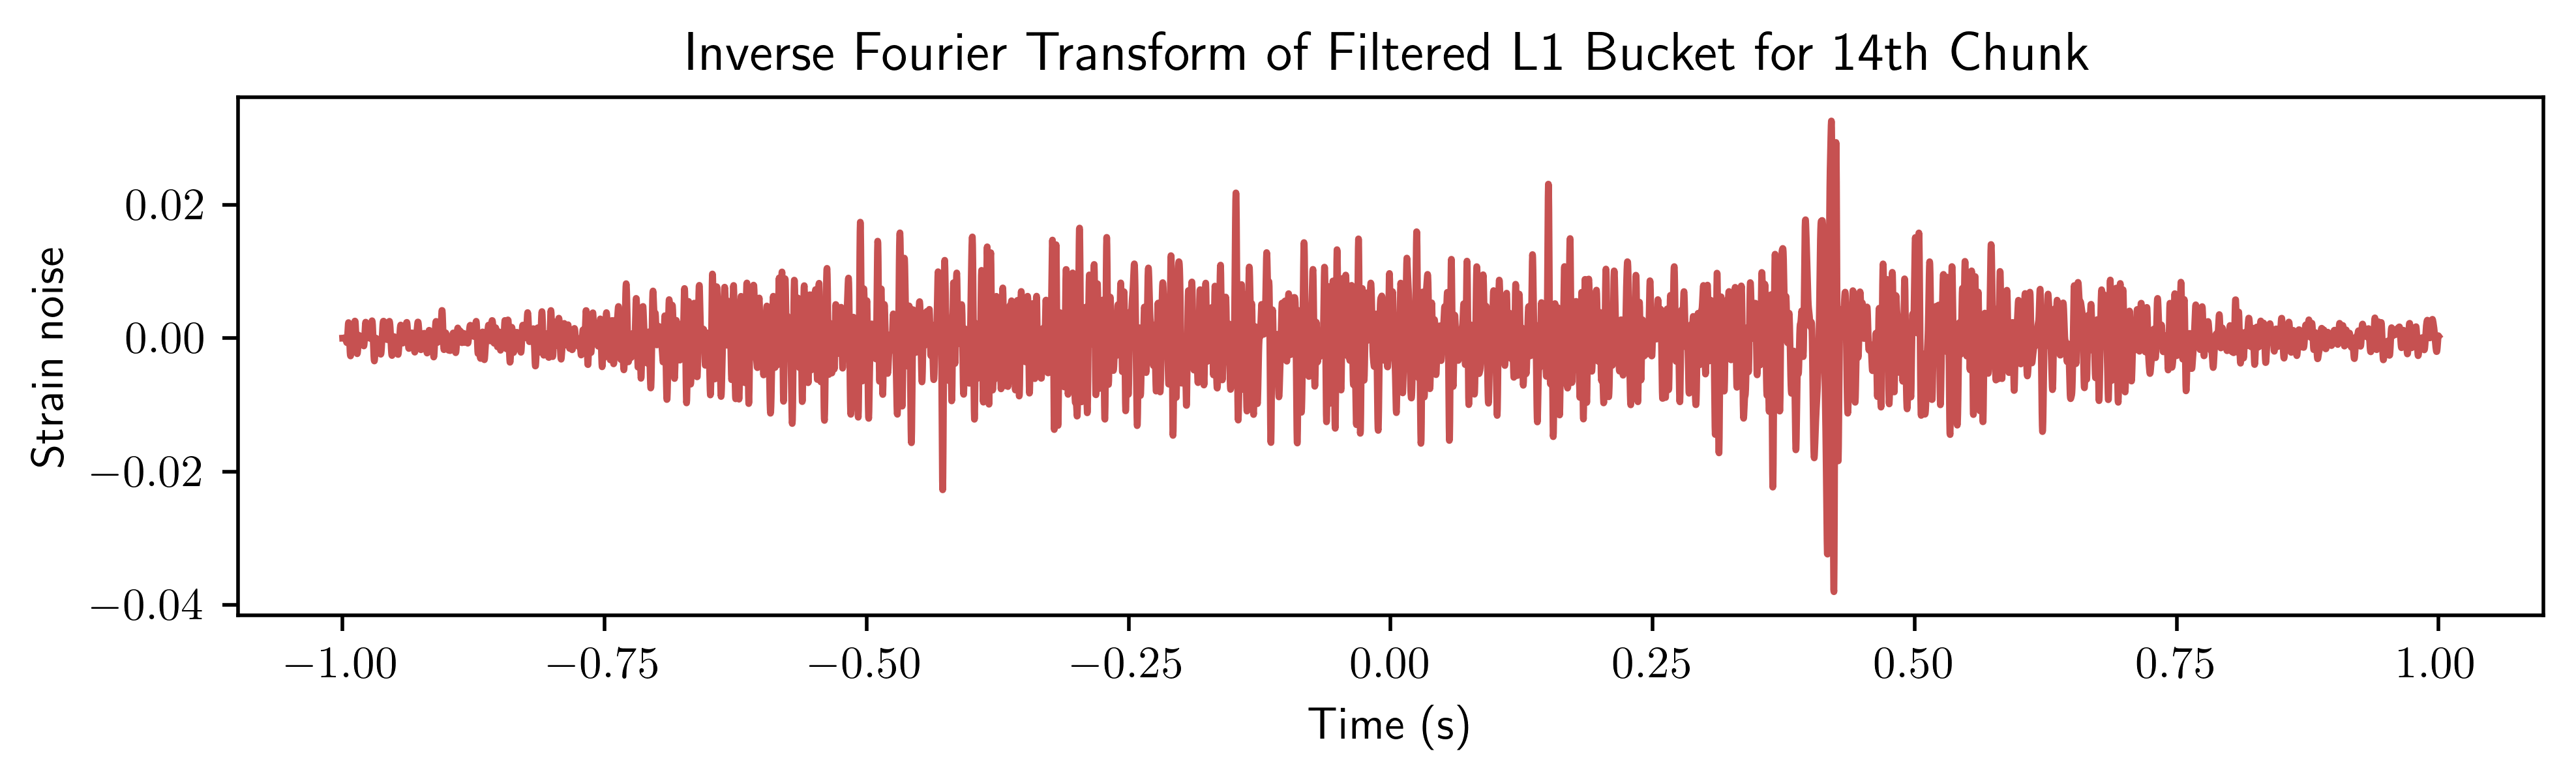

In [33]:
centred_chunk_time_axis = np.linspace(-1,1, sample_rate*2)

plot7 = plt.figure(7, figsize=(8,2.5), dpi=500)
line = plt.plot(centred_chunk_time_axis, filtered_inverse_butterworth_H1_data[14],color='#008037')
plt.title("Inverse Fourier Transform of Filtered H1 Bucket for 14th Chunk")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.tight_layout()
plt.savefig('H1chunk.png')
plt.show()

plot8 = plt.figure(8, figsize=(8,2.5), dpi=500)
line = plt.plot(centred_chunk_time_axis, filtered_inverse_butterworth_L1_data[14], color='#c65151')
plt.title("Inverse Fourier Transform of Filtered L1 Bucket for 14th Chunk")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.tight_layout()
plt.savefig('L1chunk.png')
plt.show()

## Generation of Spectrogram

We generate a spectrogram in order to get a better sense of how to frequency of the signal evolves over the given time frame. Unfortunately, compared to the original detection paper, the choice of our initial data was of the lower quality variant and thus we get more pixelation than is seen there.

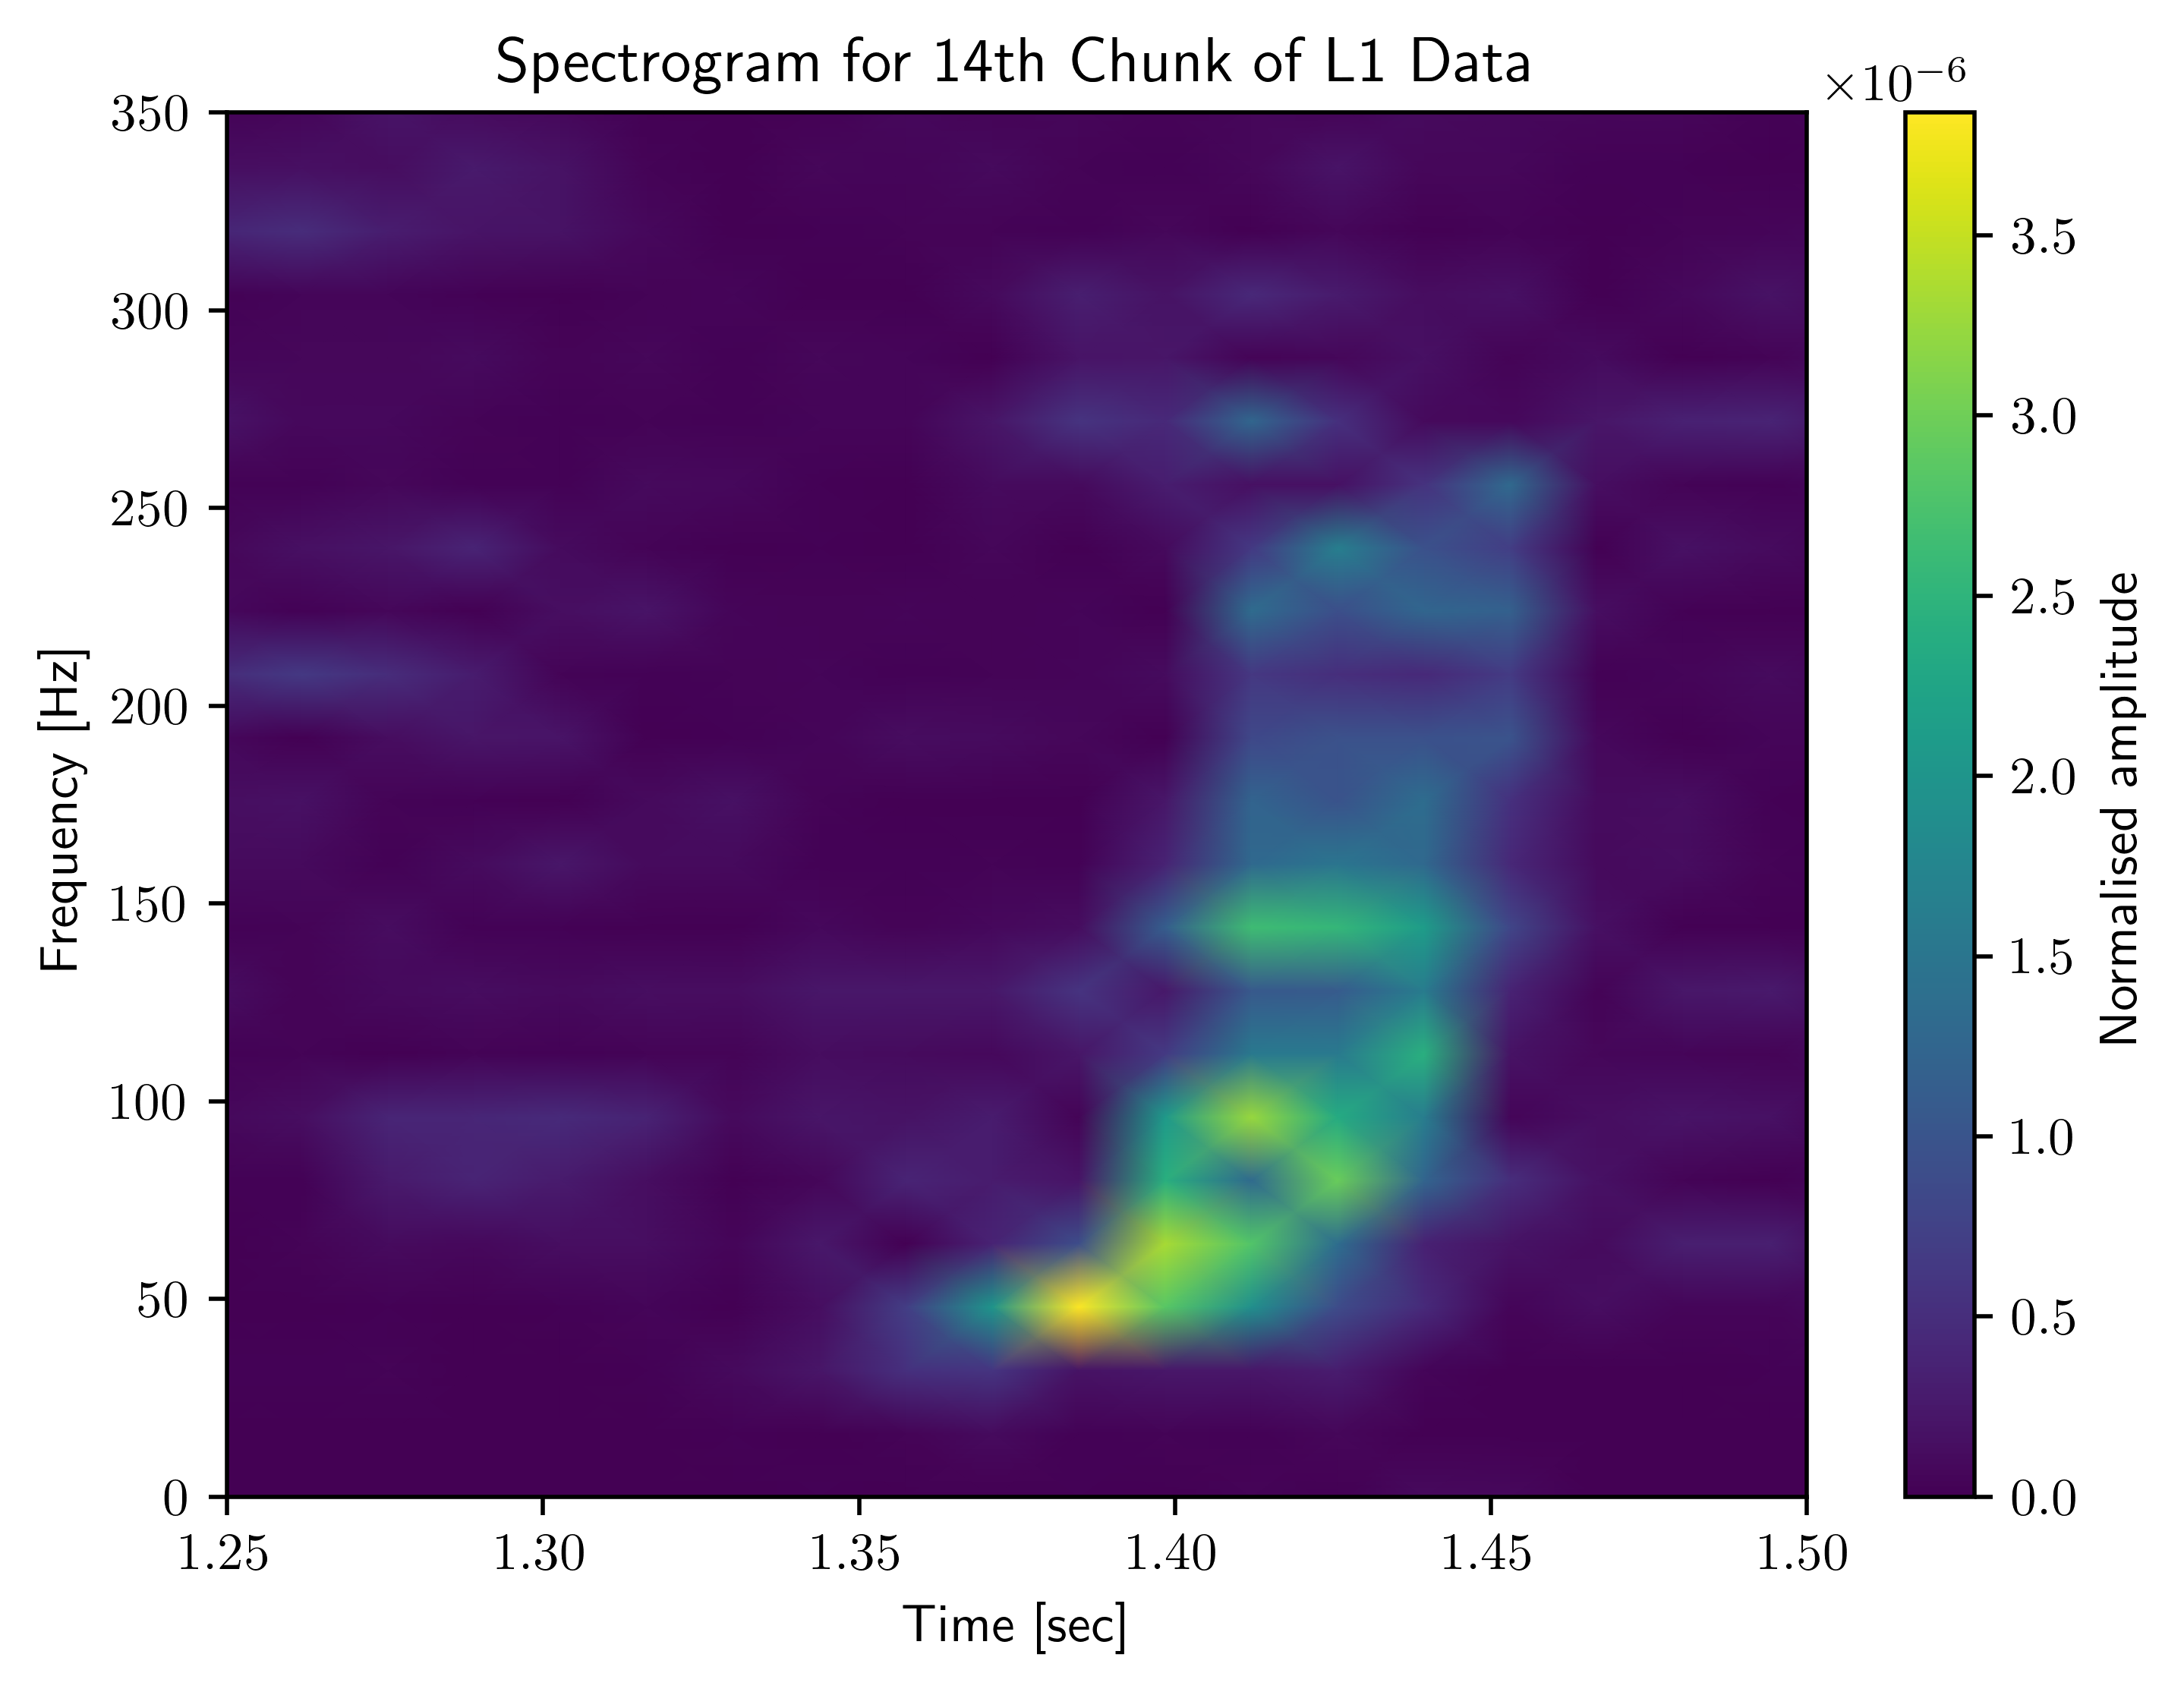

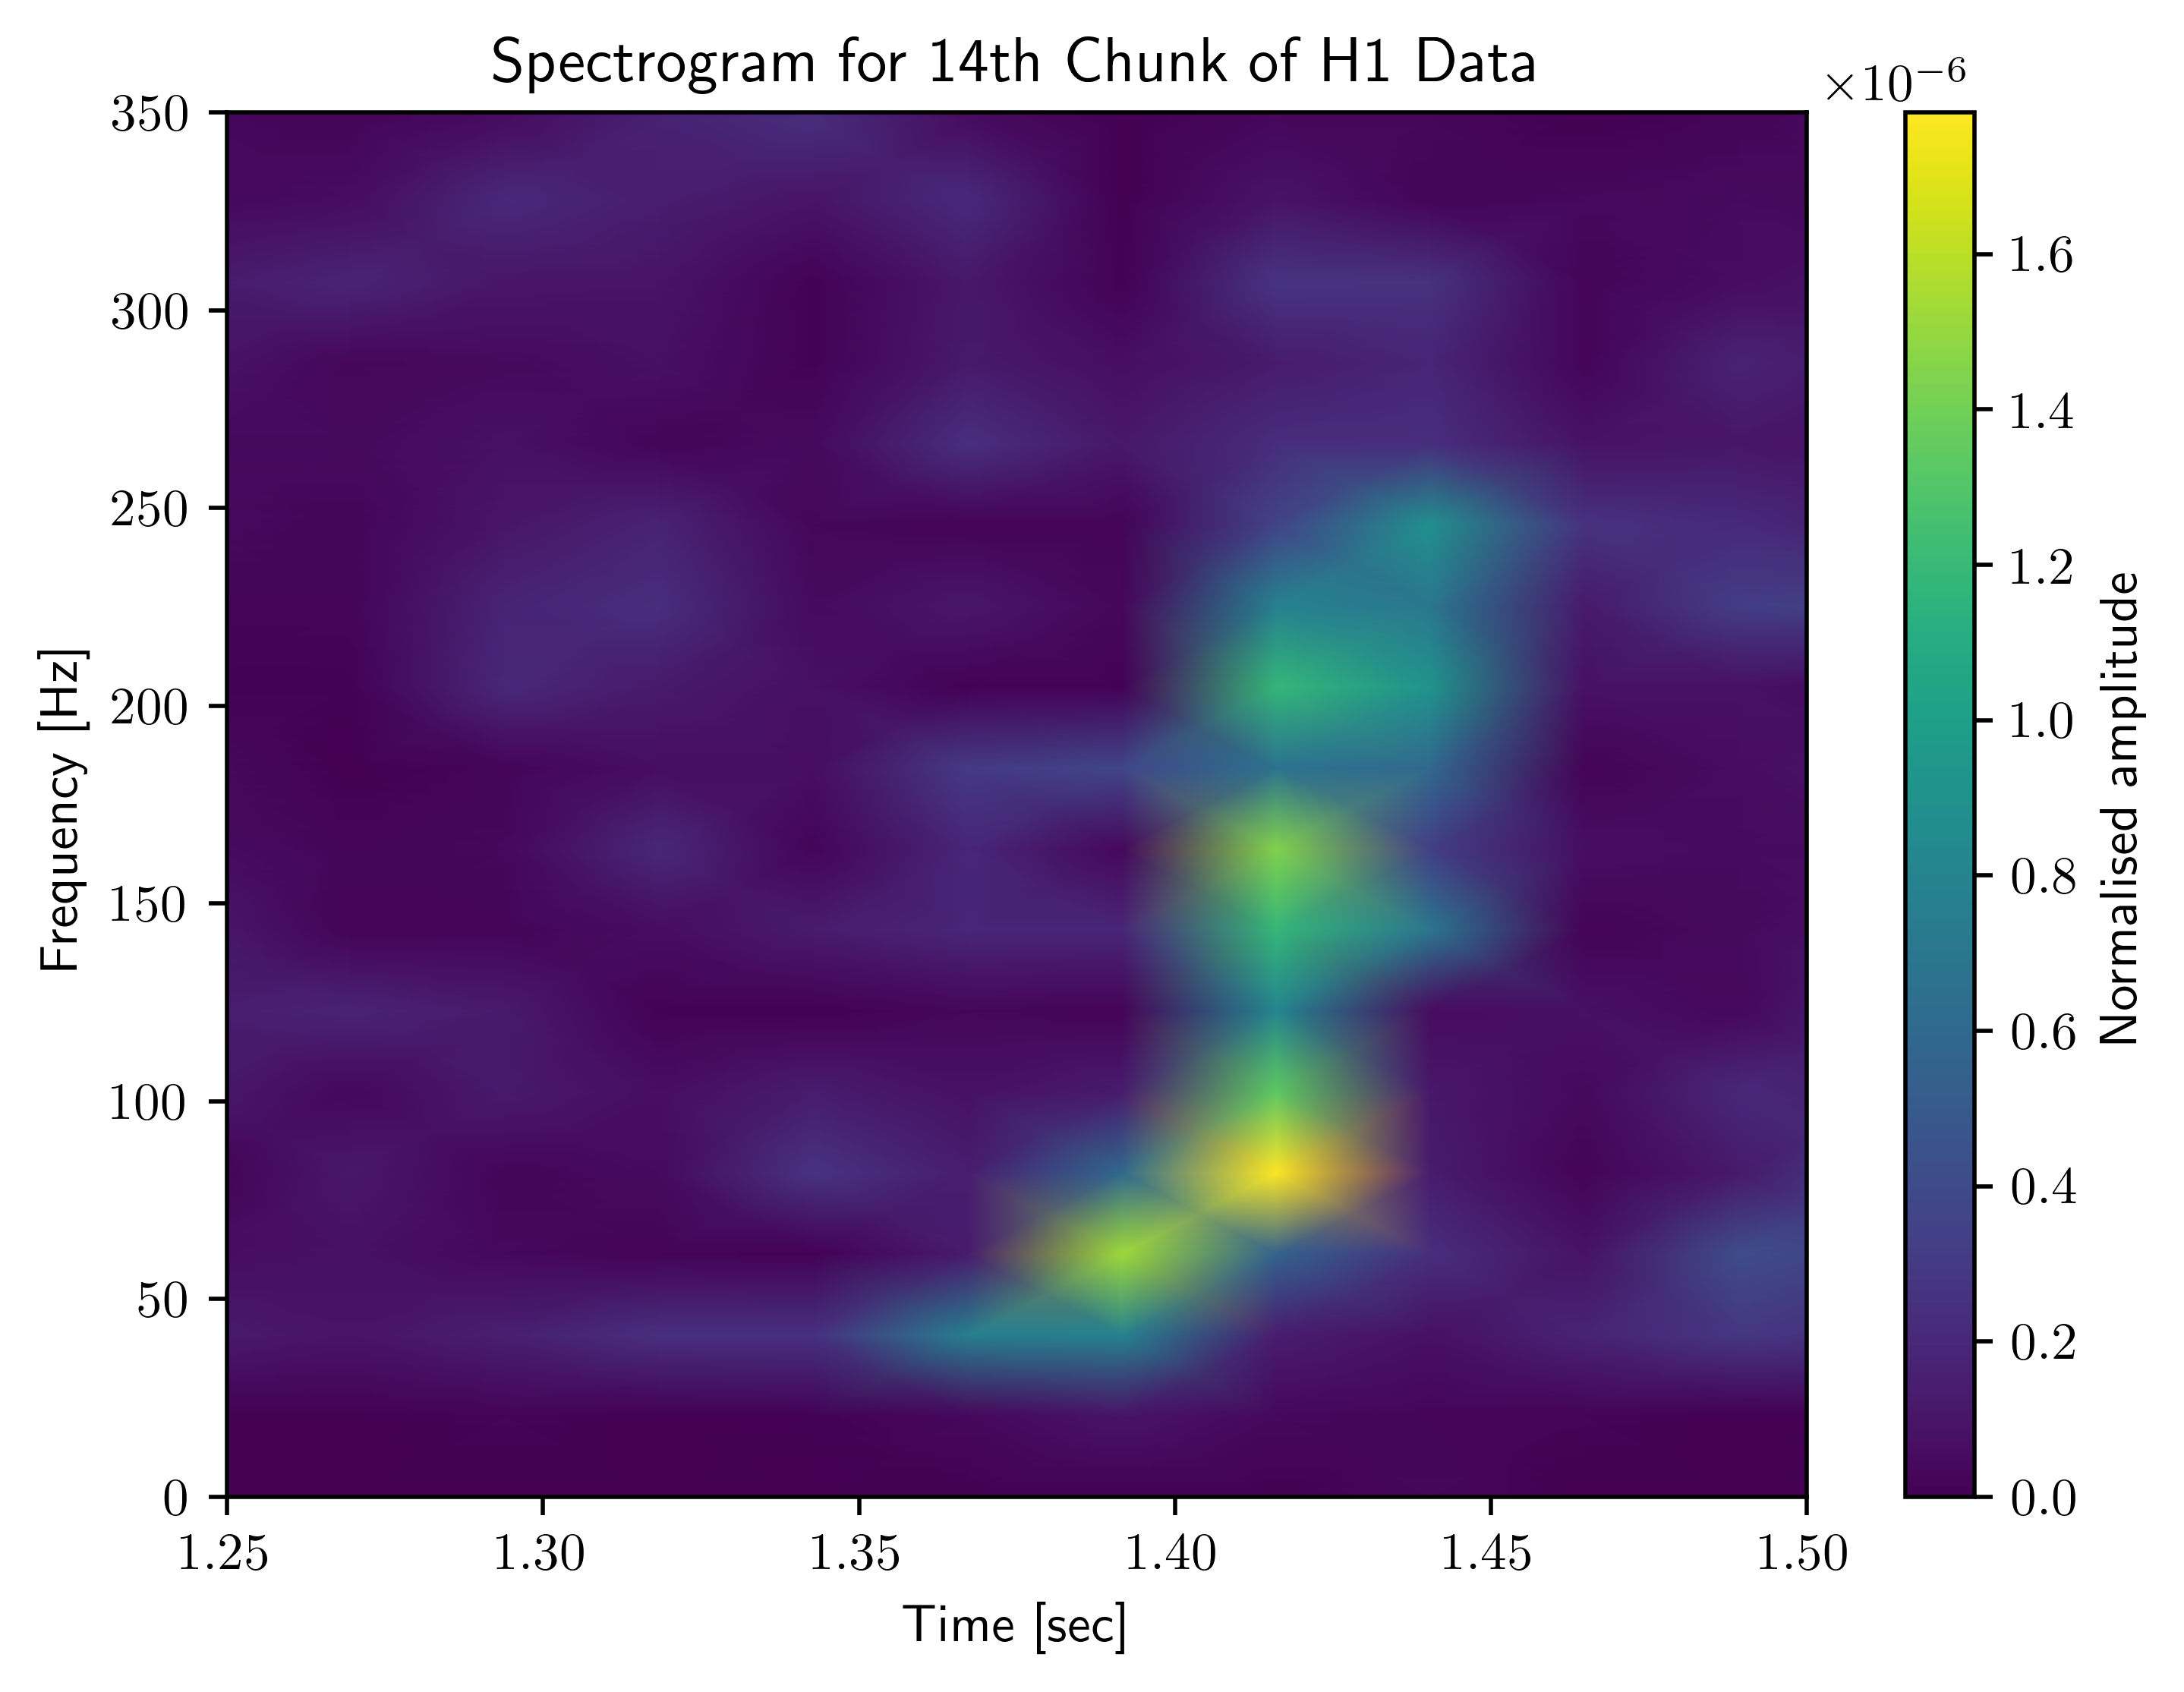

In [40]:
# We use the scipy spectrogram with the H1 data and a no. overlap of 200 which was tuned by playing with the param.
f,t,Sxx = sig.spectrogram(filtered_inverse_butterworth_H1_data[14], sample_rate, noverlap=200)

plot9 = plt.figure(9, figsize=(6,4.5), dpi=500)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
cbar = plt.colorbar()
cbar.set_label('Normalised amplitude', rotation=90)
plt.ylim(0,350)
plt.ylabel('Frequency [Hz]')
plt.xlim(1.25,1.5)
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.title('Spectrogram for 14th Chunk of L1 Data')
plt.savefig('L1chunkspec.png')
plt.show()

f,t,Sxx = sig.spectrogram(filtered_inverse_butterworth_L1_data[14], sample_rate, noverlap=100, nperseg=200)

plot10 = plt.figure(10, figsize=(6,4.5), dpi=500)

plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylim(0,350)
cbar = plt.colorbar()
cbar.set_label('Normalised amplitude', rotation=90)
plt.ylabel('Frequency [Hz]')
plt.xlim(1.25,1.5)
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.title('Spectrogram for 14th Chunk of H1 Data')
plt.savefig('H1chunkspec.png')
plt.show()

As we can see, in both datasets, we get a signal which increase in frequency over time, a bit like a chirp. 

## 7 Conversion into a Sound

This sound conversion is quite similar to the one produced by Caltech for their demonstration video: https://www.ligo.caltech.edu/video/ligo20160211v2

In [52]:
Audio(np.real(filtered_inverse_butterworth_H1_data[14]), rate=sample_rate)

## 8 Creating a Matched Filter for the Data

Below we attempt to use the matched filter technique presented by https://www.icts.res.in/sites/default/files/gws2015-chris-van-den-broeck-2015-07-08-tutorial.pdf. We do so by downloading their filter bank and applying it to the raw data for the 14th chunk.

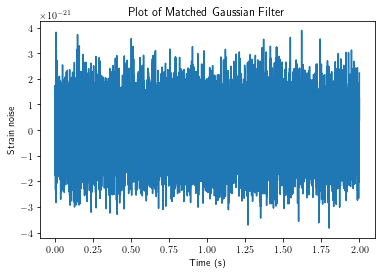

In [55]:
# Import dat data
filter_bank_raw_data = np.genfromtxt('gw_ex_data.dat',
                     skip_header=1,
                     skip_footer=1,
                     names=True,
                     dtype='f8',
                     delimiter=' ')

float_filter_bank = []

# Conversion of filter bank into python float
for (x,y) in filter_bank_raw_data:
    if y != '<f8':
        float_filter_bank.append([x,y])
    else:
        float_filter_bank.append([x,0])

plt.plot(np.linspace(0,2,len(float_filter_bank)), [item[1] for item in float_filter_bank])
plt.title("Plot of Matched Gaussian Filter")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()


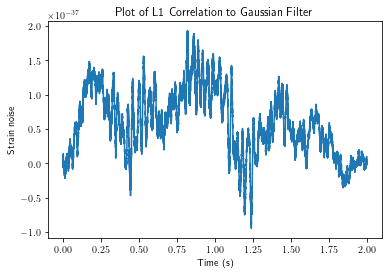

In [59]:
# We get the section of H1 and L1 data corresponding to the detection
H1_section = H1_data[4096*14:4096*14+16381]
L1_section = L1_data[4096*14:4096*14+16381]

filter_y_values = [item[1] for item in float_filter_bank]

# We apply the correlation filter as provided by scipy
H1_correlation = sig.correlate(H1_section, filter_y_values)
L1_correlation = sig.correlate(L1_section, filter_y_values)

plt.plot(np.linspace(0,2,len(float_filter_bank)*2-1), L1_correlation)
plt.title("Plot of L1 Correlation to Gaussian Filter")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()

This approach does not seem to produce the kind of results we are looking for. So instead, we apply the Gaussian filter to the normalised 14th chunk with a time range of 1 to 1.8 seconds

In [81]:
gauss_filtered_14_H1_chunk = sig.correlate(inverse_normalised_tukey_chunked_rfft_H1_data[14][sample_rate:int(1.8*sample_rate)], filter_y_values)
gauss_filtered_14_L1_chunk = sig.correlate(inverse_normalised_tukey_chunked_rfft_L1_data[14][sample_rate:int(1.8*sample_rate)], filter_y_values)

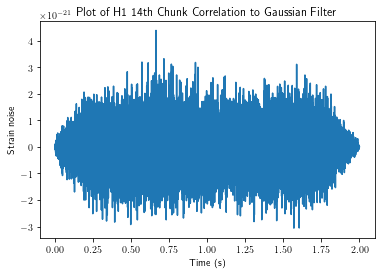

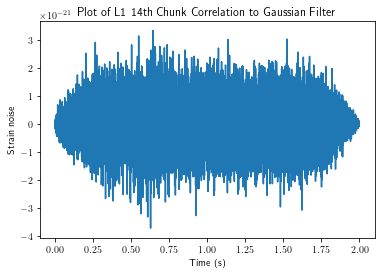

In [82]:
plt.plot(np.linspace(0,2,len(gauss_filtered_14_H1_chunk)), gauss_filtered_14_H1_chunk)
plt.title("Plot of H1 14th Chunk Correlation to Gaussian Filter")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()

plt.plot(np.linspace(0,2,len(gauss_filtered_14_L1_chunk)), gauss_filtered_14_L1_chunk)
plt.title("Plot of L1 14th Chunk Correlation to Gaussian Filter")
plt.xlabel("Time (s)")
plt.ylabel("Strain noise")
plt.show()

This also does not have the desried effect. As such it is believed that the wrong methodology has been employed for the application of the matched filter. If more time was provided for the lab, a review of the paper would have been completed and a more valid method would have been attempted.